In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
from collections import deque
import os
from arch.univariate import ARX,GARCH,arch_model
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import display
import pylab
import warnings
warnings.simplefilter('ignore')

In [2]:
def get_pricing(csv = '../data/INFY.csv'):
    df = pd.read_csv(csv, index_col = 'Date')
    df = df[df.index > '2010-01-01']
    cl = pd.DataFrame(df['Close'])
    cl['logClose'] = np.log(cl['Close'])
    cl['diffLogClose'] = cl['logClose'] - cl['logClose'].shift(1)
    cl['pctChange'] = cl['Close'].pct_change()
    cl = cl.dropna()
    return cl

In [3]:
def generate_sample_garch(n=1000, omega=0.2, a1=0.5, b1=0.3):
    # > a0 <- 0.2
    # > a1 <- 0.5
    # > b1 <- 0.3
    # > w <- rnorm(10000)
    # > eps <- rep(0, 10000)
    # > sigsq <- rep(0, 10000)
    # > for (i in 2:10000) {
    # >   sigsq[i] <- a0 + a1 * (eps[i-1]^2) + b1 * sigsq[i-1]
    # >   eps[i] <- w[i]*sqrt(sigsq[i])
    # > }
    w = np.random.randn(n)
    sigsq = np.zeros_like(w)
    eps = np.zeros_like(w)
    for i in range(1,n):
        sigsq[i] = omega + a1*(eps[i-1]**2) + b1*sigsq[i-1]
        eps[i] = np.sqrt(sigsq[i])*w[i]
    return eps

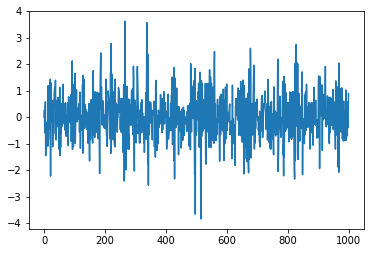

In [4]:
proc = generate_sample_garch()
# plot_acf(proc, lags=30)
plt.plot(proc)
plt.show()
# plt.show()
# plot_acf(proc**2, lags=30)
# plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1198.3712401715836
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1198.1945021800964
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1187.2211910705214
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1186.6539385967092
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1182.3900536913745
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1182.0720872439188
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1181.123335390977
Iteration:      8,   Func. Count:     57,   Neg. LLF: 1181.1171055755685
Iteration:      9,   Func. Count:     63,   Neg. LLF: 1181.1167944318884
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1181.1167860059018
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1181.116786005683
            Iterations: 10
            Function evaluations: 69
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results     

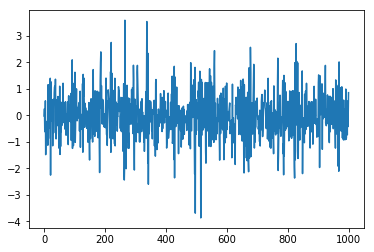

In [5]:
am = arch_model(y=proc)
print(am.fit().summary())
plt.plot(am.fit().resid)
plt.show()

In [6]:
def determine_arma_order(values):
    finalmodel = None
    finalorder = (0,0)
    finalaic = np.inf
    for p,d,q in product(list(range(5)), range(2), list(range(5))):
        #         print("testing ARIMA(p,d,q) for (%d, %d, %d)"%(p,d,q))
        try:
            test = ARIMA(endog=values, order=(p,d,q))
            tf = test.fit(method='mle', trend='c')
            aic = tf.aic
            if aic < finalaic:
                finalaic = aic
                finalorder = (p,d,q)
                finalmodel = test
        except:
            continue
            #             print("Cannot fit for (%d,%d, %d)"%(p,d, q))
    print("ARIMA final order, AIC: ", finalorder, finalaic)
    finalmodel = ARIMA(endog=values, order=finalorder).fit(method='mle', trend='c')
    return finalmodel, finalorder, finalaic

def determine_garch_order(values):
    finalmodel = None
    finalorder = (0,0)
    finalaic = np.inf
    for p,q in product(list(range(1,2)),list(range(1,2))):
        # print("testing GARCH(p,q) for (%d, %d)"%(p,q))
        try:
            test = arch_model(values, p=p, q=q)
            tf = test.fit(disp='off')
            aic = tf.aic
            if aic < finalaic:
                finalaic = aic
                finalorder = (p,q)
                finalmodel = tf
        except Exception as e:
            print(e)
            continue
            #             print("Cannot fit for (%d,%d, %d)"%(p,d, q))
    print("GARCH final order, AIC: ", finalorder, finalaic)
    #finalmodel = arch_model(values, p=finalorder[0], q=finalorder[1]).fit(disp='off')
    return finalmodel, finalorder, finalaic

    

def ljung_box(finalmodel):
    resid = finalmodel.resid
    #Ljung-box test to determine whether ARMA(p,q) is a good fit
    lbxresid = acorr_ljungbox(resid, lags=20)
    df = pd.DataFrame()
    df['test-Stat Q value'] = lbxresid[0]
    df['p-value'] = lbxresid[1]
    df['reject'] = df['p-value']<=0.05
    display(df)

In [7]:
nfty = get_pricing(csv='../data/NIFTY 50.csv')
print(nfty.head())
nftyval = nfty['diffLogClose'].values
today = nftyval[-1]
nftyval = nftyval[-501:-1] #consider only last 500 values
# model, order, aic = determine_arma_order(nftyval)

              Close  logClose  diffLogClose  pctChange
Date                                                  
2010-01-05  5277.90  8.571284      0.008696   0.008734
2010-01-06  5281.80  8.572022      0.000739   0.000739
2010-01-07  5263.10  8.568475     -0.003547  -0.003540
2010-01-08  5244.75  8.564983     -0.003493  -0.003487
2010-01-11  5249.40  8.565869      0.000886   0.000887


In [8]:
def backtester(values, windowsize=500):
    d = windowsize
    signals = []
    for i in range(len(values) - d):
        print("computing for (%d-%d)"%(i,i+d))
        window = values[i:i+d]
        model, order, aic = determine_arma_order(window)
        amfit, amorder, amaic = determine_garch_order(model.resid)
        # amfit = arch_model(model.resid, p=order[0], q=order[2], o=order[1], dist='normal').fit(disp='off')
        forecast = amfit.forecast(horizon=1,start=None, align='origin')
        signals.append(np.sign(forecast.mean['h.1'].iloc[-1]))
        print(np.sign(forecast.mean['h.1'].iloc[-1]))
#     print(signals)
    return signals

ARIMA final order, AIC:  (2, 0, 1) -3011.959685957488
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  500
Model:                     ARMA(2, 1)   Log Likelihood                1510.980
Method:                           mle   S.D. of innovations              0.012
Date:                Tue, 04 Jun 2019   AIC                          -3011.960
Time:                        00:57:26   BIC                          -2990.887
Sample:                             0   HQIC                         -3003.691
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.308      0.758      -0.001       0.001
ar.L1.y       -0.7215      0.142     -5.079      0.000      -1.000      -0.44

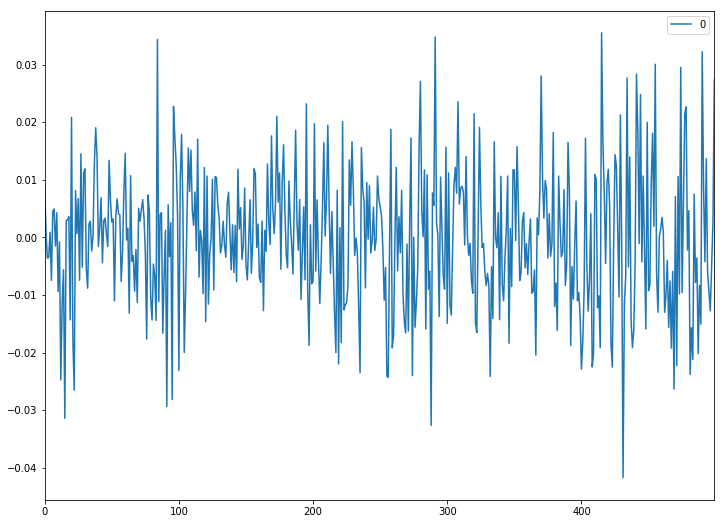

In [9]:
warnings.simplefilter('ignore')
nfty = get_pricing(csv='../data/NIFTY 50.csv')
vals = nfty['diffLogClose'].values
vals = vals[:501]
test = vals[-1]
vals = vals[:-1]
model, order, aic = determine_arma_order(vals)
gm = arch_model(vals)
gmfit = gm.fit(disp='off')
print(model.summary())
print(gmfit.summary())
ws, ts = 252,200 #windowsize,testsize
# vals = vals[(ws+ts):]
# print(len(vals))
pd.DataFrame(vals).plot(figsize=(12,9))
# signals = backtester(vals, windowsize=ws)


In [13]:
print(gmfit.summary())
def forecast(ar=(0.2, 0.1), ma=(0.4), garch_omega = 1e-6, garch_alpha=0.05, garch_beta=0.93):
    

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                1518.25
Distribution:                  Normal   AIC:                          -3028.51
Method:            Maximum Likelihood   BIC:                          -3011.65
                                        No. Observations:                  500
Date:                Tue, Jun 04 2019   Df Residuals:                      496
Time:                        00:57:26   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3694e-04  1.252e-04      1.893  5.838e-02 

In [10]:
testsize=ts
print(vals[-testsize:])
# print(signals)
# print(np.sign(vals[-testsize:]) == signals)

[-1.49076401e-02  1.12219264e-02 -1.17725720e-02 -1.34840565e-02
 -1.66690762e-03  9.11070819e-03  1.21902355e-02  7.66182805e-03
  2.35949264e-02  5.81935249e-03  8.59629230e-03  8.90321744e-03
  7.93368128e-03 -1.32077756e-03  1.40442890e-02  2.70761943e-04
 -3.10122433e-03 -1.02738717e-03 -7.45247615e-03 -9.68384805e-03
  2.15102504e-02 -1.48178631e-02 -1.65232929e-02  2.03141349e-03
  1.91338089e-02  5.63208960e-03 -1.73481233e-03 -1.03892574e-03
 -5.89629388e-03 -8.33958540e-03 -6.23325049e-03 -8.41867549e-03
 -2.41523117e-02 -5.06197939e-03 -1.40586111e-02  1.66378380e-02
 -6.30485790e-05 -1.77599924e-03  4.28586234e-03 -1.42792349e-02
  1.06247997e-02 -8.28527660e-03 -1.09802300e-02 -3.37951710e-03
  1.38265436e-03  1.06740244e-02 -1.83580835e-02  1.53968903e-03
 -8.54451484e-03  1.17830994e-02  1.17097894e-02 -5.47985255e-04
  1.57799028e-02  5.71191862e-03 -7.47601610e-03 -6.07207005e-03
  2.76953330e-03  4.34697028e-03 -5.28738938e-03 -1.04997339e-03
 -6.40512417e-03 -5.47016

In [11]:
print(nfty.head())

              Close  logClose  diffLogClose  pctChange
Date                                                  
2010-01-05  5277.90  8.571284      0.008696   0.008734
2010-01-06  5281.80  8.572022      0.000739   0.000739
2010-01-07  5263.10  8.568475     -0.003547  -0.003540
2010-01-08  5244.75  8.564983     -0.003493  -0.003487
2010-01-11  5249.40  8.565869      0.000886   0.000887


In [12]:
print(np.cumsum(vals[-testsize:]))
print(np.cumsum(np.array(vals[-testsize:])* np.array(signals)))
plt.figure(figsize=(12,9))
plt.plot(np.cumsum(vals[-testsize:]), label = 'buy and hold')
plt.plot(np.cumsum(np.array(vals[-testsize:])* np.array(signals)), label='arima+garch')
pylab.legend(loc='upper left')
plt.show()

[-1.49076401e-02 -3.68571367e-03 -1.54582857e-02 -2.89423422e-02
 -3.06092498e-02 -2.14985416e-02 -9.30830614e-03 -1.64647809e-03
  2.19484483e-02  2.77678008e-02  3.63640931e-02  4.52673105e-02
  5.32009918e-02  5.18802142e-02  6.59245032e-02  6.61952651e-02
  6.30940408e-02  6.20666536e-02  5.46141775e-02  4.49303294e-02
  6.64405798e-02  5.16227168e-02  3.50994238e-02  3.71308373e-02
  5.62646463e-02  6.18967359e-02  6.01619235e-02  5.91229978e-02
  5.32267039e-02  4.48871185e-02  3.86538680e-02  3.02351925e-02
  6.08288086e-03  1.02090146e-03 -1.30377096e-02  3.60012840e-03
  3.53707983e-03  1.76108058e-03  6.04694292e-03 -8.23229203e-03
  2.39250763e-03 -5.89276897e-03 -1.68729990e-02 -2.02525161e-02
 -1.88698617e-02 -8.19583725e-03 -2.65539207e-02 -2.50142317e-02
 -3.35587465e-02 -2.17756472e-02 -1.00658577e-02 -1.06138430e-02
  5.16605982e-03  1.08779784e-02  3.40196234e-03 -2.67010771e-03
  9.94255913e-05  4.44639588e-03 -8.40993507e-04 -1.89096690e-03
 -8.29609108e-03 -8.84310

NameError: name 'signals' is not defined